In [1]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/kaggle/input/ravdess/Actor_02/03-02-01-01-01-01-02.wav')

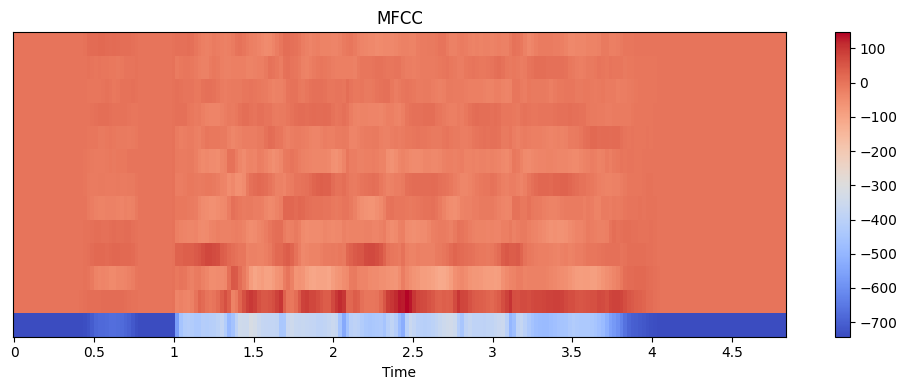

In [2]:
import librosa
from librosa import display
import matplotlib.pyplot as plt

# Load audio file
data, sampling_rate = librosa.load('/kaggle/input/ravdess/Actor_02/03-02-01-01-01-01-02.wav')

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


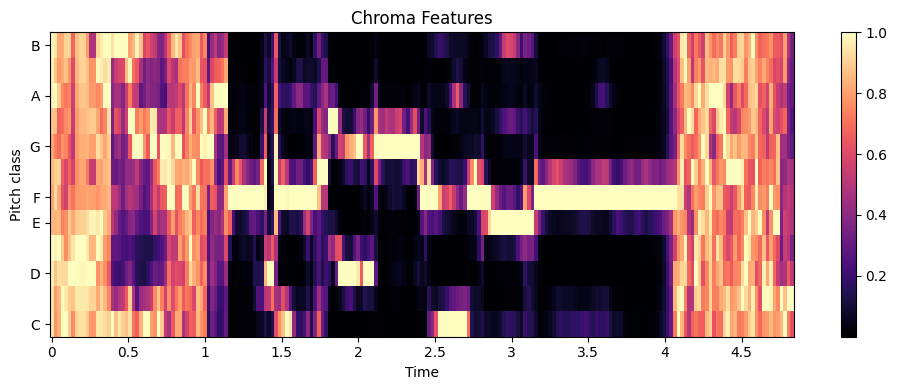

In [3]:
import librosa
from librosa import display
import matplotlib.pyplot as plt

# Load audio file
data, sampling_rate = librosa.load('/kaggle/input/ravdess/Actor_02/03-02-01-01-01-01-02.wav')

# Compute chroma features
chroma = librosa.feature.chroma_stft(y=data, sr=sampling_rate)

# Plot chroma features
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Features')
plt.tight_layout()
plt.show()


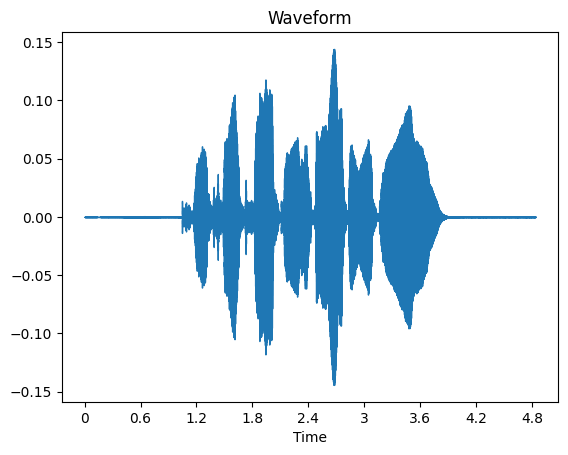

Original Audio:


In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

librosa.display.waveshow(data, sr=sampling_rate)
plt.title('Waveform')
plt.show()


import IPython.display as ipd

print("Original Audio:")
ipd.display(ipd.Audio(data, rate=sampling_rate))


In [5]:
data_directory='/kaggle/input/ravdess'
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

2024-05-13 22:45:34.658315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 22:45:34.658432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 22:45:34.844521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
def extract_feature(data, sr, mfcc, chroma, mel):

    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))

    return result


def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data


def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data


def load_data(save=False):

    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y

X, y = load_data(save=True)

# X = np.load("X.npy")
# y = np.load("y.npy")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

In [7]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5}


In [8]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [9]:
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))
opt = Adam(learning_rate=0.001)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1671 - loss: 3.0436

I0000 00:00:1715640646.193133     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715640646.213146     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2041 - loss: 2.6313

W0000 00:00:1715640651.604913     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715640652.455480     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.2056 - loss: 2.6176 - val_accuracy: 0.3887 - val_loss: 1.7320
Epoch 2/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3999 - loss: 1.6546

W0000 00:00:1715640654.204942     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4111 - loss: 1.6350 - val_accuracy: 0.5731 - val_loss: 1.3702
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5621 - loss: 1.2842 - val_accuracy: 0.6298 - val_loss: 1.1072
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6446 - loss: 1.0775 - val_accuracy: 0.7075 - val_loss: 0.9053
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7381 - loss: 0.8740 - val_accuracy: 0.7708 - val_loss: 0.8036
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7702 - loss: 0.7881 - val_accuracy: 0.8182 - val_loss: 0.7016
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7868 - loss: 0.7324 - val_accuracy: 0.8340 - val_loss: 0.6536
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8226 - loss: 0.6408 - val_accuracy: 0.8485 - val_loss: 0.6000
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8263 - loss: 0.6233 - val_accuracy: 0.8722 - val_loss: 0.5589
Epo

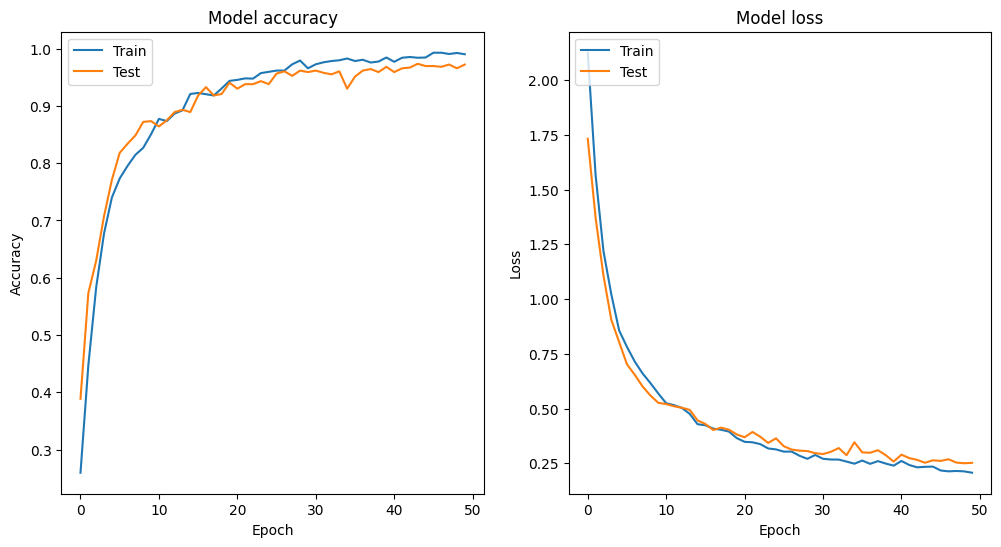

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Expand dimensions for Conv1D input
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)

# Train the model
history = model.fit(XProccessed, y_train, epochs=50, batch_size=64, validation_data=(XTestProcessed, y_test))

# Plot training history: accuracy vs loss
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()




In [ ]:
# Fit the model with early stopping callback
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

# Print best training and validation metrics
best_train_loss = min(history.history['loss'])
best_train_acc = max(history.history['accuracy'])
best_val_loss = min(history.history['val_loss'])
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Training Loss: {best_train_loss}")
print(f"Best Training Accuracy: {best_train_acc}")
print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Validation Accuracy: {best_val_acc}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(XTestProcessed, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Define optimizer
opt = 'adam'

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Expand dimensions for Conv1D input
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)


In [ ]:
# Fit the model with early stopping callback
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64, callbacks=[early_stopping])

# Print best training and validation metrics
best_train_loss = min(history.history['loss'])
best_train_acc = max(history.history['accuracy'])
best_val_loss = min(history.history['val_loss'])
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Training Loss: {best_train_loss}")
print(f"Best Training Accuracy: {best_train_acc}")
print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Validation Accuracy: {best_val_acc}")


# **LSTM**

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the model
model_lstm = Sequential()

# LSTM layer
model_lstm.add(LSTM(units=64, input_shape=(180, 1), return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.5))

# Dense layer
model_lstm.add(Dense(8, activation='softmax'))

# Compile the model
opt_lstm = 'adam'
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt_lstm, metrics=['accuracy'])

# Early stopping callback

# Fit the model
history_lstm = model_lstm.fit(XProccessed, y_train, epochs=110, validation_data=(XTestProcessed, y_test), batch_size=64)

# Print best training and validation metrics
best_train_loss_lstm = min(history_lstm.history['loss'])
best_train_acc_lstm = max(history_lstm.history['accuracy'])
best_val_loss_lstm = min(history_lstm.history['val_loss'])
best_val_acc_lstm = max(history_lstm.history['val_accuracy'])

print(f"Best Training Loss (LSTM): {best_train_loss_lstm}")
print(f"Best Training Accuracy (LSTM): {best_train_acc_lstm}")
print(f"Best Validation Loss (LSTM): {best_val_loss_lstm}")
print(f"Best Validation Accuracy (LSTM): {best_val_acc_lstm}")
# Evaluate the model on test data
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(XTestProcessed, y_test)
print(f"Test Loss (LSTM): {test_loss_lstm}")
print(f"Test Accuracy (LSTM): {test_acc_lstm}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1949 - loss: 1.9945 - val_accuracy: 0.1818 - val_loss: 1.8091
Epoch 2/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1824 - loss: 1.8423 - val_accuracy: 0.1647 - val_loss: 1.7972
Epoch 3/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1948 - loss: 1.8028 - val_accuracy: 0.2161 - val_loss: 1.7601
Epoch 4/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2955 - loss: 1.6882 - val_accuracy: 0.2780 - val_loss: 1.6509
Epoch 5/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3323 - loss: 1.5888 - val_accuracy: 0.3109 - val_loss: 1.5433
Epoch 6/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3276 - loss: 1.5452 - val_accuracy: 0.3478 - val_loss: 1.5284
Epoch 7/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3497 - loss: 1.5303 - val_accuracy: 0.3399 - val_loss: 1.5438
Epoch 8/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3348 - loss: 1.5349 - val_accuracy: 0.

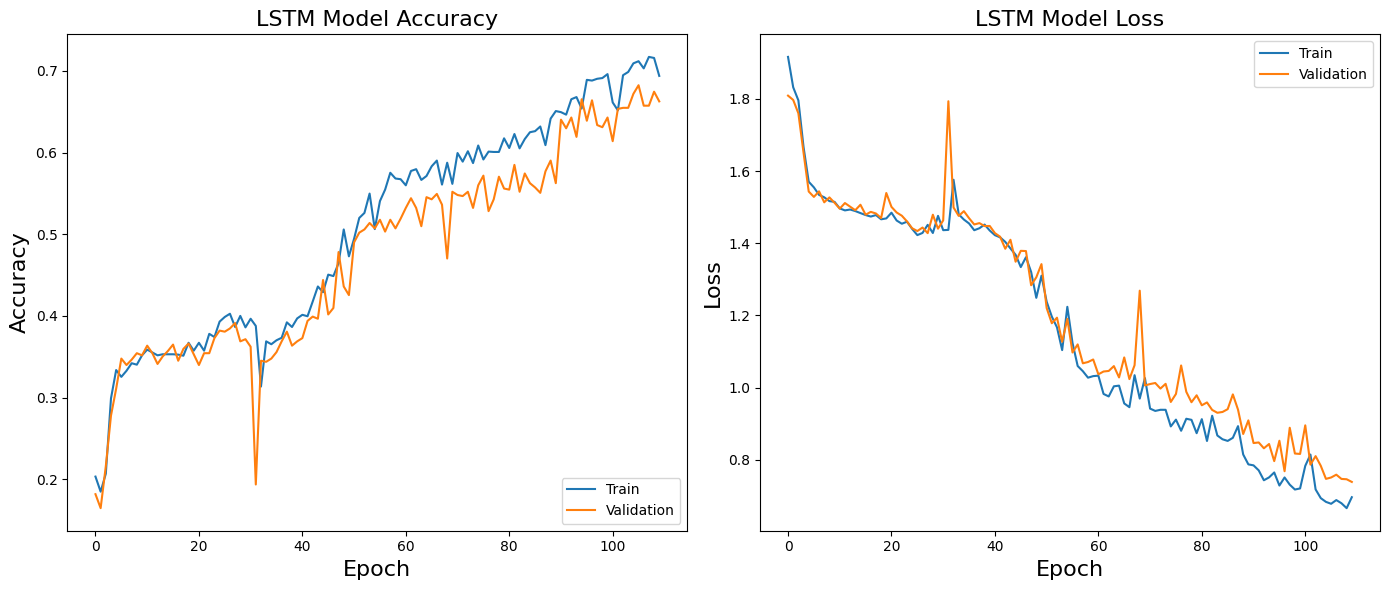

In [21]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation accuracy values
axs[0].plot(history_lstm.history['accuracy'], label='Train')
axs[0].plot(history_lstm.history['val_accuracy'], label='Validation')
axs[0].set_title('LSTM Model Accuracy',fontsize=16)
axs[0].set_ylabel('Accuracy',fontsize=16)
axs[0].set_xlabel('Epoch',fontsize=16)
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history_lstm.history['loss'], label='Train')
axs[1].plot(history_lstm.history['val_loss'], label='Validation')
axs[1].set_title('LSTM Model Loss',fontsize=16)
axs[1].set_ylabel('Loss',fontsize=16)
axs[1].set_xlabel('Epoch',fontsize=16)
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()



In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the model
model_bilstm = Sequential()

# BiLSTM layer
model_bilstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(180, 1)))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Bidirectional(LSTM(units=64)))
model_bilstm.add(Dropout(0.5))

# Dense layer
model_bilstm.add(Dense(8, activation='softmax'))

# Compile the model
opt_bilstm = 'adam'
model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer=opt_bilstm, metrics=['accuracy'])

# Fit the model
history_bilstm = model_bilstm.fit(XProccessed, y_train, epochs=110, validation_data=(XTestProcessed, y_test), batch_size=64)

# Print best training and validation metrics
best_train_loss_bilstm = min(history_bilstm.history['loss'])
best_train_acc_bilstm = max(history_bilstm.history['accuracy'])
best_val_loss_bilstm = min(history_bilstm.history['val_loss'])
best_val_acc_bilstm = max(history_bilstm.history['val_accuracy'])

print(f"Best Training Loss (BiLSTM): {best_train_loss_bilstm}")
print(f"Best Training Accuracy (BiLSTM): {best_train_acc_bilstm}")
print(f"Best Validation Loss (BiLSTM): {best_val_loss_bilstm}")
print(f"Best Validation Accuracy (BiLSTM): {best_val_acc_bilstm}")
# Evaluate the model on test data
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(XTestProcessed, y_test)
print(f"Test Loss (BiLSTM): {test_loss_bilstm}")
print(f"Test Accuracy (BiLSTM): {test_acc_bilstm}")


Epoch 1/110


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1900 - loss: 1.9226 - val_accuracy: 0.2121 - val_loss: 1.7642
Epoch 2/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2305 - loss: 1.7807 - val_accuracy: 0.2899 - val_loss: 1.6670
Epoch 3/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2733 - loss: 1.6730 - val_accuracy: 0.3004 - val_loss: 1.5862
Epoch 4/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2996 - loss: 1.6109 - val_accuracy: 0.3267 - val_loss: 1.5696
Epoch 5/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3043 - loss: 1.5567 - val_accuracy: 0.3663 - val_loss: 1.4615
Epoch 6/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3627 - loss: 1.4512 - val_accuracy: 0.3715 - val_loss: 1.4380
Epoch 7/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3807 - loss: 1.4649 - val_accuracy: 0.4203 - val_loss: 1.3491
Epoch 8/110
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4486 - loss: 1.3665 - val_accuracy: 0.4177 - val_l

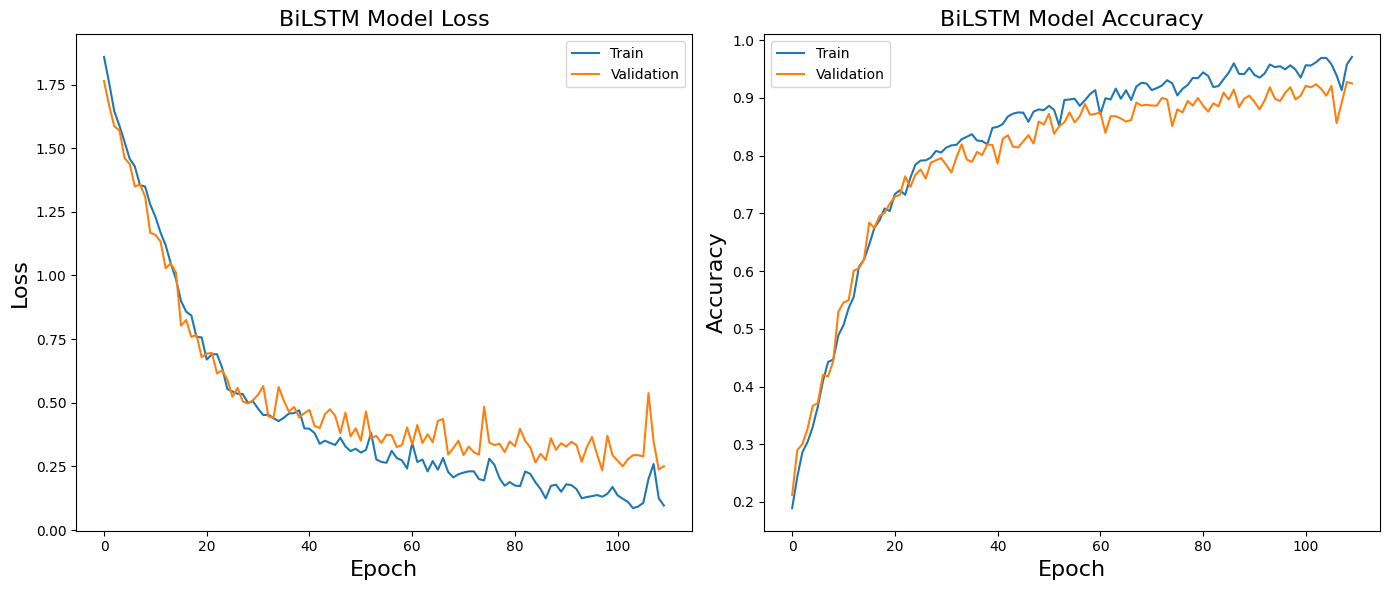

In [25]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss values
axs[0].plot(history_bilstm.history['loss'], label='Train')
axs[0].plot(history_bilstm.history['val_loss'], label='Validation')
axs[0].set_title('BiLSTM Model Loss', fontsize=16)  # Increase title font size
axs[0].set_ylabel('Loss', fontsize=16)  # Increase ylabel font size
axs[0].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[0].legend()

# Plot training & validation accuracy values
axs[1].plot(history_bilstm.history['accuracy'], label='Train')
axs[1].plot(history_bilstm.history['val_accuracy'], label='Validation')
axs[1].set_title('BiLSTM Model Accuracy', fontsize=16)  # Increase title font size
axs[1].set_ylabel('Accuracy', fontsize=16)  # Increase ylabel font size
axs[1].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[1].legend()

plt.tight_layout()
plt.show()


# **GRU**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the model
model_gru = Sequential()

# GRU layer
model_gru.add(GRU(units=64, return_sequences=True, input_shape=(180, 1)))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(units=64))
model_gru.add(Dropout(0.5))

# Dense layer
model_gru.add(Dense(8, activation='softmax'))

# Compile the model
opt_gru = Adam()
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer=opt_gru, metrics=['accuracy'])

# Fit the model
history_gru = model_gru.fit(XProccessed, y_train, epochs=180, validation_data=(XTestProcessed, y_test), batch_size=64)

# Print best training and validation metrics
best_train_loss_gru = min(history_gru.history['loss'])
best_train_acc_gru = max(history_gru.history['accuracy'])
best_val_loss_gru = min(history_gru.history['val_loss'])
best_val_acc_gru = max(history_gru.history['val_accuracy'])

print(f"Best Training Loss (GRU): {best_train_loss_gru}")
print(f"Best Training Accuracy (GRU): {best_train_acc_gru}")
print(f"Best Validation Loss (GRU): {best_val_loss_gru}")
print(f"Best Validation Accuracy (GRU): {best_val_acc_gru}")
# Evaluate the model on test data
test_loss_gru, test_acc_gru = model_gru.evaluate(XTestProcessed, y_test)

print(f"Test Loss (GRU): {test_loss_gru}")
print(f"Test Accuracy (GRU): {test_acc_gru}")


Epoch 1/180


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1790 - loss: 2.0091 - val_accuracy: 0.1818 - val_loss: 1.8420
Epoch 2/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1807 - loss: 1.8382 - val_accuracy: 0.1647 - val_loss: 1.8104
Epoch 3/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1797 - loss: 1.8140 - val_accuracy: 0.1989 - val_loss: 1.7971
Epoch 4/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1619 - loss: 1.8201 - val_accuracy: 0.1792 - val_loss: 1.7953
Epoch 5/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1880 - loss: 1.8023 - val_accuracy: 0.1713 - val_loss: 1.7912
Epoch 6/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1792 - loss: 1.7990 - val_accuracy: 0.1792 - val_loss: 1.7895
Epoch 7/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1999 - loss: 1.7835 - val_accuracy: 0.1989 - val_loss: 1.7881
Epoch 8/180
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1721 - loss: 1.7862 - val_accuracy: 0.1647 - val_l

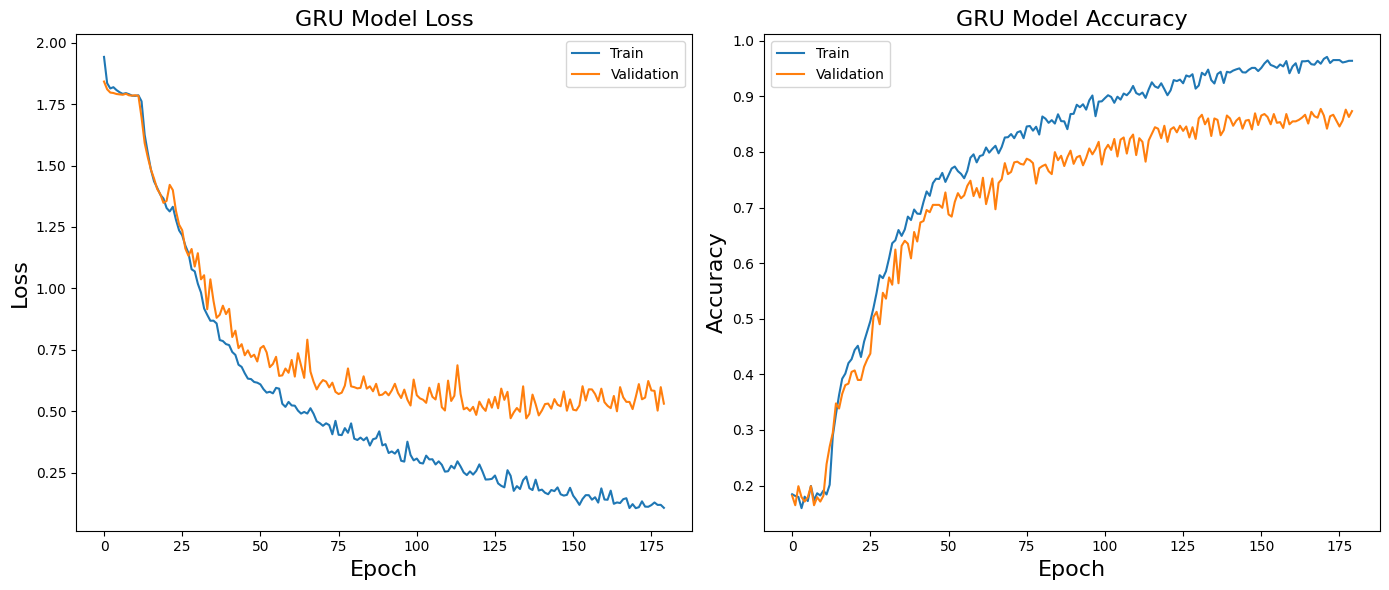

In [27]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss values
axs[0].plot(history_gru.history['loss'], label='Train')
axs[0].plot(history_gru.history['val_loss'], label='Validation')
axs[0].set_title('GRU Model Loss', fontsize=16)  # Increase title font size
axs[0].set_ylabel('Loss', fontsize=16)  # Increase ylabel font size
axs[0].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[0].legend()

# Plot training & validation accuracy values
axs[1].plot(history_gru.history['accuracy'], label='Train')
axs[1].plot(history_gru.history['val_accuracy'], label='Validation')
axs[1].set_title('GRU Model Accuracy', fontsize=16)  # Increase title font size
axs[1].set_ylabel('Accuracy', fontsize=16)  # Increase ylabel font size
axs[1].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[1].legend()

plt.tight_layout()
plt.show()


In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(180, 1)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(8, activation='softmax'))

# Define BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(180, 1)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(units=64)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(8, activation='softmax'))

# Define input layers
lstm_input = Input(shape=(180, 1))
bilstm_input = Input(shape=(180, 1))

# Get outputs from LSTM and BiLSTM models
lstm_output = lstm_model(lstm_input)
bilstm_output = bilstm_model(bilstm_input)

# Concatenate the outputs of both models
concatenated = concatenate([lstm_output, bilstm_output])

# Combine the models
ensemble_output = Dense(8, activation='softmax')(concatenated)
ensemble_model = Model(inputs=[lstm_input, bilstm_input], outputs=ensemble_output)


# Compile the ensemble model
opt_ensemble = Adam()
ensemble_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_ensemble, metrics=['accuracy'])

# Fit the ensemble model
history_ensemble = ensemble_model.fit([XProccessed, XProccessed], y_train, epochs=200, validation_data=([XTestProcessed, XTestProcessed], y_test), batch_size=32)

# Evaluate the model on test data
test_loss, test_accuracy = ensemble_model.evaluate([XTestProcessed, XTestProcessed], y_test)

# Print best training and validation metrics
best_train_loss_ensemble = min(history_ensemble.history['loss'])
best_train_acc_ensemble = max(history_ensemble.history['accuracy'])
best_val_loss_ensemble = min(history_ensemble.history['val_loss'])
best_val_acc_ensemble = max(history_ensemble.history['val_accuracy'])

print(f"Best Training Loss (Ensemble): {best_train_loss_ensemble}")
print(f"Best Training Accuracy (Ensemble): {best_train_acc_ensemble}")
print(f"Best Validation Loss (Ensemble): {best_val_loss_ensemble}")
print(f"Best Validation Accuracy (Ensemble): {best_val_acc_ensemble}")
print(f"Test Loss (Ensemble): {test_loss}")
print(f"Test Accuracy (Ensemble): {test_accuracy}")


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.1371 - loss: 2.0265 - val_accuracy: 0.2213 - val_loss: 1.9326
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1955 - loss: 1.9145 - val_accuracy: 0.2213 - val_loss: 1.8867
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2299 - loss: 1.8703 - val_accuracy: 0.2675 - val_loss: 1.8384
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3025 - loss: 1.8074 - val_accuracy: 0.2503 - val_loss: 1.8172
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3306 - loss: 1.7554 - val_accuracy: 0.2806 - val_loss: 1.7510
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3166 - loss: 1.7185 - val_accuracy: 0.2925 - val_loss: 1.7109
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3232 - loss: 1.6887 - val_accuracy: 0.2991 - val_loss: 1.6828
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3312 - loss: 1.6480 - val_accuracy: 0.2925 - val_l

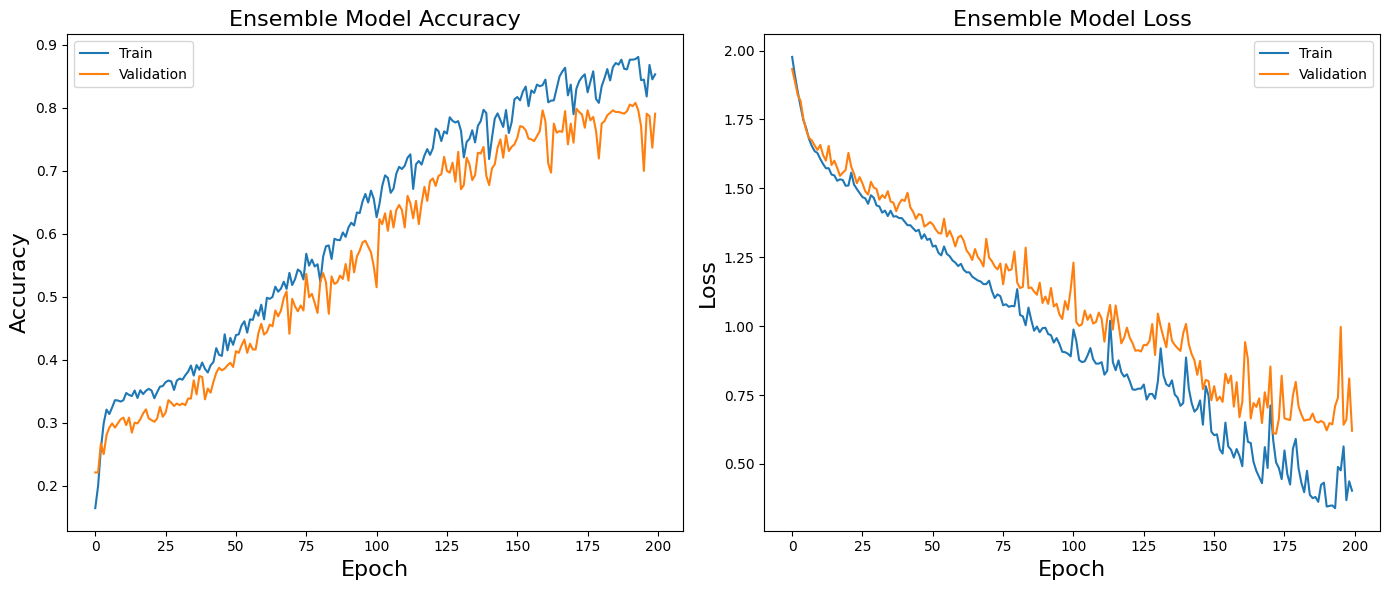

In [23]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss values
axs[1].plot(history_ensemble.history['loss'], label='Train')
axs[1].plot(history_ensemble.history['val_loss'], label='Validation')
axs[1].set_title('Ensemble Model Loss',fontsize=16)
axs[1].set_ylabel('Loss',fontsize=16)
axs[1].set_xlabel('Epoch',fontsize=16)
axs[1].legend()

# Plot training & validation accuracy values
axs[0].plot(history_ensemble.history['accuracy'], label='Train')
axs[0].plot(history_ensemble.history['val_accuracy'], label='Validation')
axs[0].set_title('Ensemble Model Accuracy',fontsize=16)
axs[0].set_ylabel('Accuracy',fontsize=16)
axs[0].set_xlabel('Epoch',fontsize=16)
axs[0].legend()

plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.layers import GRU

# Define GRU model
gru_model = Sequential()
gru_model.add(GRU(units=64, return_sequences=True, input_shape=(180, 1)))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=64))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(8, activation='softmax'))

# Define input layers
gru_input = Input(shape=(180, 1))

# Get output from GRU model
gru_output = gru_model(gru_input)

# Concatenate the outputs of BiLSTM and GRU models
concatenated = concatenate([bilstm_output, gru_output])

# Combine the models
ensemble_output = Dense(8, activation='softmax')(concatenated)
ensemble_model = Model(inputs=[bilstm_input, gru_input], outputs=ensemble_output)

# Compile the ensemble model
opt_ensemble = Adam()
ensemble_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_ensemble, metrics=['accuracy'])

# Fit the ensemble model
history_ensemble = ensemble_model.fit([XProccessed, XProccessed], y_train, epochs=200, validation_data=([XTestProcessed, XTestProcessed], y_test), batch_size=32)

# Evaluate the model on test data
test_loss, test_accuracy = ensemble_model.evaluate([XTestProcessed, XTestProcessed], y_test)

# Print best training and validation metrics
best_train_loss_ensemble = min(history_ensemble.history['loss'])
best_train_acc_ensemble = max(history_ensemble.history['accuracy'])
best_val_loss_ensemble = min(history_ensemble.history['val_loss'])
best_val_acc_ensemble = max(history_ensemble.history['val_accuracy'])

print(f"Best Training Loss (Ensemble): {best_train_loss_ensemble}")
print(f"Best Training Accuracy (Ensemble): {best_train_acc_ensemble}")
print(f"Best Validation Loss (Ensemble): {best_val_loss_ensemble}")
print(f"Best Validation Accuracy (Ensemble): {best_val_acc_ensemble}")
print(f"Test Loss (Ensemble): {test_loss}")
print(f"Test Accuracy (Ensemble): {test_accuracy}")


Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.1124 - loss: 2.0513 - val_accuracy: 0.1634 - val_loss: 1.9095
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1875 - loss: 1.8887 - val_accuracy: 0.1726 - val_loss: 1.8398
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1856 - loss: 1.8281 - val_accuracy: 0.2635 - val_loss: 1.7947
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.1979 - loss: 1.7956 - val_accuracy: 0.2648 - val_loss: 1.7640
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2819 - loss: 1.7494 - val_accuracy: 0.2530 - val_loss: 1.7304
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2455 - loss: 1.7247 - val_accuracy: 0.2740 - val_loss: 1.6985
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2768 - loss: 1.6910 - val_accuracy: 0.2477 - val_loss: 1.6618
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3174 - loss: 1.6311 - val_accuracy: 0.

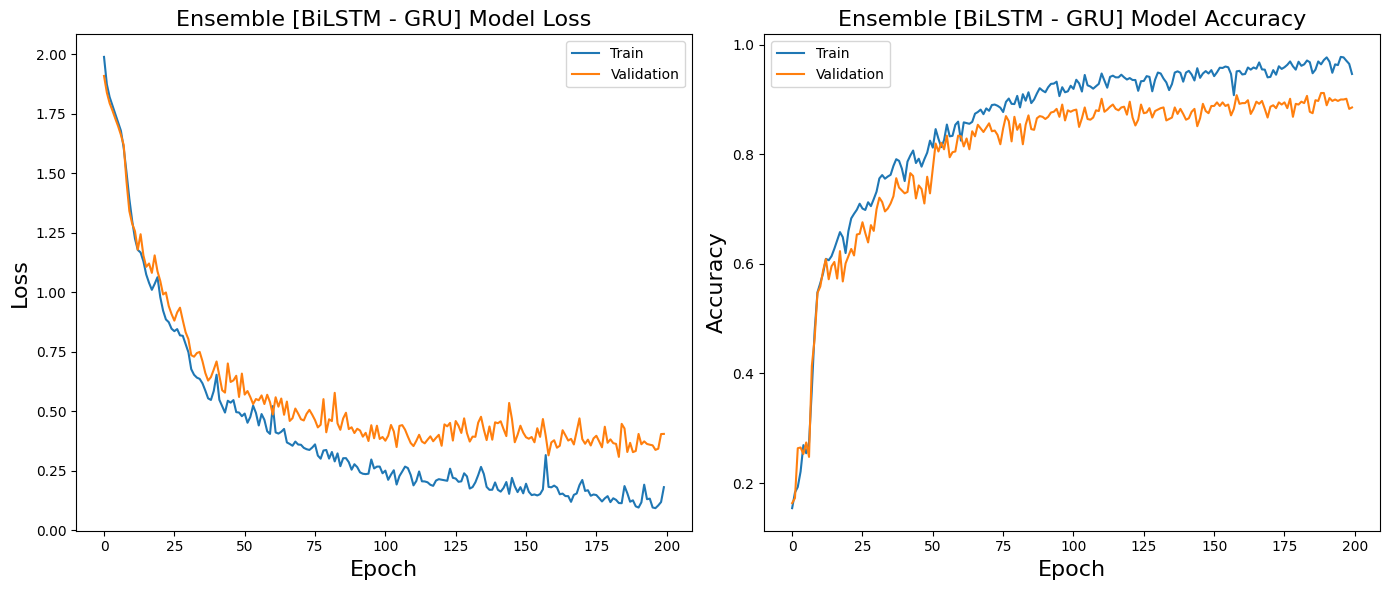

In [30]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss values
axs[0].plot(history_ensemble.history['loss'], label='Train')
axs[0].plot(history_ensemble.history['val_loss'], label='Validation')
axs[0].set_title('Ensemble [BiLSTM - GRU] Model Loss', fontsize=16)  # Increase title font size
axs[0].set_ylabel('Loss', fontsize=16)  # Increase ylabel font size
axs[0].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[0].legend()

# Plot training & validation accuracy values
axs[1].plot(history_ensemble.history['accuracy'], label='Train')
axs[1].plot(history_ensemble.history['val_accuracy'], label='Validation')
axs[1].set_title('Ensemble [BiLSTM - GRU] Model Accuracy', fontsize=16)  # Increase title font size
axs[1].set_ylabel('Accuracy', fontsize=16)  # Increase ylabel font size
axs[1].set_xlabel('Epoch', fontsize=16)  # Increase xlabel font size
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Save the ensemble model
ensemble_model.save("ensemble_model.h5")

